# imports

In [1]:
# Dataset preprocessor to prepare the data for training
import numpy as np
import torch
from time import time
import scipy.io as sio
import matplotlib.pyplot as plt

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.monocular import MultiDataset
import NTdatasets.conway.cloud_datasets as datasets

import NDNT.utils as utils # some other utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils

import sys
sys.path.append('./lib')
import runner2 as r
import model as m
import experiment as exp
import plot

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


In [2]:
datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08'
#fn = 'Jocamo_220727_full_CC_ETCC_nofix_v08'
num_lags=12

# load data

In [3]:
t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
# TODO: should we not trial_sample?
t1 = time()
print(t1-t0, 'sec elapsed')

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
98.35370230674744 sec elapsed


In [4]:
NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

print(lam_units, 'laminar units', data.robs.shape, 'robs', data.dfs.shape, 'dfs')

167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 128 129 130
 131 132 133 134 135 136 137 138 139 140 141] laminar units torch.Size([167520, 239]) robs torch.Size([167520, 239]) dfs


21 out of 29 units used
Output set to 21 cells


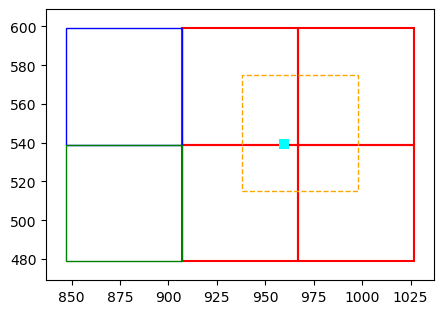

  Stim expansion for shift: [918, 495, 1018, 595]
  Writing lam stim 0: overlap 49, 44
  Writing lam stim 1: overlap 49, 56
  Writing lam stim 2: overlap 51, 56
  Writing lam stim 3: overlap 51, 44
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [5]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, lam_units], data.dfs[:, lam_units]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
vallam = lam_units[a]
NCv = len(vallam)
print("%d out of %d units used"%(len(vallam), len(lam_units)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_cornerUT = matdat['top_corner'][:, 0]

data.set_cells(vallam)

# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

# TODO: this should be passed in as a parameter
top_corner_lam = [938, 515]

# Make 60x60 STAs (and GLMs)
Xshift = 0 #8+4 
Yshift = 0 #-10+4
NX = 60

new_tc = np.array([top_corner_lam[0]-Xshift, top_corner_lam[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts)


goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix

In [6]:
# TODO: fit a GQM
# TODO: update the dataset params to the runner to be cleaner
# TODO: update the model to not copy-paste.
#       Instead, have a single layer allowing any params and setting the internal_layer_type.
# TODO: fit the GLM2
# TODO: fit a deeper network with STConv (e.g. make sure I can use an STConv layer in my model API)

# dry-run model fitting

In [7]:
glm_layer = m.TemporalLayer(
    NLtype=m.NL.softplus,
    bias=True,
    initialize_center=True,
    num_lags=num_lags,
    reg_vals={'d2xt': r.Sample(default=0.01, typ=r.RandomType.float, values=[0.01], start=0.00001, end=0.1),
              'l1': r.Sample(default=0.0001, typ=r.RandomType.float, values=[0.0001], start=0.00001, end=0.001),
              'bcs': {'d2xt': 1}})

inp_stim = m.Input(covariate='stim', input_dims=data.stim_dims)

glm_net = m.Network(layers=[glm_layer],
                    name='glm')
# this is set as a starting point, but updated on each iteration
output_11 = m.Output(num_neurons=1)

inp_stim.to(glm_net)
glm_net.to(output_11)
glm_model = m.Model(output_11,
                    name='GLM',
                    create_NDN=False, verbose=True)

changing last dimension of input_dims to be 1


In [8]:
# set the cells to a single cell
data.set_cells([vallam[0]])

trainer_params = r.TrainerParams(num_lags=num_lags,
                                 device="cuda:1", # use the second GPU
                                 max_epochs=1, # just for testing
                                 batch_size=20,
                                 history_size=100,
                                 include_MUs=True,
                                 init_num_samples=0,
                                 bayes_num_steps=0,
                                 num_initializations=1,
                                 block_sample=True,
                                 trainer_type=r.TrainerType.lbfgs)

runner = r.Runner(experiment_name='color_exps_01',
                  dataset_expt=[fn], # name of the experiment
                  #dataset_expt='/home/dbutts/ColorV1/CLRworkspace/',
                  #datadir='/home/dbutts/ColorV1/Data/',
                  dataset=data,
                  dataset_on_gpu=False,
                  model_template=glm_model,
                  trainer_params=trainer_params,
                  overwrite=True,
                  trial_params={})
runner.run()

# fix the issue where it is trying to index into the block_inds using the timepoints
# WHY IS THIS HAPPENING?!?!?

Output set to 1 cells
Experiment color_exps_01 is already finished. Exiting.


# look at exp

In [9]:
e = exp.load('color_exps_01', experiment_location='../experiments')
e.trials_df

,trial_idx,model_name,expt,"(0, 0, reg_vals, d2xt)","(0, 0, reg_vals, l1)",name,trial,mean_LLs
0,0,GLM,Jocamo_220715_full_CC_ETCC_nofix_v08,0.01,0.0001,GLM0,<experiment.Trial object at 0x7fe0589b2a50>,-2.027393


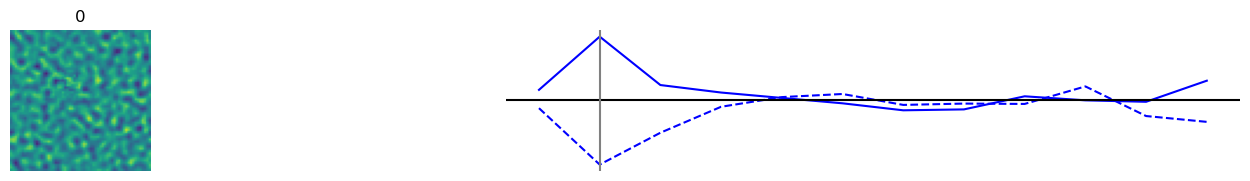

In [10]:
e.trials[0].model.NDN.plot_filters()

# combined model

In [11]:
# drift network
drift_dims = [1, 1, 1, data.Xdrift.shape[1]]

inp_drift = m.Input(covariate='Xdrift', input_dims=drift_dims)
drift_layer = m.Layer(
    NLtype=m.NL.linear,
    num_filters=1,
    bias=False,
    reg_vals={'d2t': r.Sample(default=Dreg, typ=r.RandomType.float, values=[Dreg], start=0.00001, end=0.1),
              'bcs': {'d2t': 0}})
drift_net = m.Network(layers=[drift_layer],
                      name='drift')

inp_stim = m.Input(covariate='stim', input_dims=data.stim_dims)

glm_layer = m.TemporalLayer(
    NLtype=m.NL.linear,
    num_filters=1,
    bias=False,
    initialize_center=True,
    num_lags=num_lags,
    reg_vals={'d2x': r.Sample(default=20, typ=r.RandomType.int, values=[20], start=10, end=30),
              'd2t': r.Sample(default=1, typ=r.RandomType.int, values=[1], start=1, end=4),
              'l1': r.Sample(default=0.1, typ=r.RandomType.float, values=[0.1], start=0.01, end=1.0),
              'glocalx': r.Sample(default=10.0, typ=r.RandomType.float, values=[10.0], start=5.0, end=15.0),
              'edge_t': r.Sample(default=10, typ=r.RandomType.int, values=[10], start=5, end=15)})
glm_net = m.Network(layers=[glm_layer],
                    name='glm')

gqm_layer = m.TemporalLayer(
    NLtype=m.NL.square,
    num_filters=2,
    bias=False,
    initialize_center=True,
    num_lags=num_lags,
    reg_vals={'d2x': r.Sample(default=20, typ=r.RandomType.int, values=[20], start=10, end=30),
              'd2t': r.Sample(default=1, typ=r.RandomType.int, values=[1], start=1, end=4),
              'l1': r.Sample(default=0.1, typ=r.RandomType.float, values=[0.1], start=0.01, end=1.0),
              'glocalx': r.Sample(default=10.0, typ=r.RandomType.float, values=[10.0], start=5.0, end=15.0),
              'edge_t': r.Sample(default=10, typ=r.RandomType.int, values=[10], start=5, end=15)})
gqm_net = m.Network(layers=[gqm_layer],
                    name='gqm')


# TODO: update runner2 to loop through cells (and track them as trials)

# this is set as a starting point, but updated on each iteration
output = m.Output(num_neurons=1)

inp_drift.to(drift_net)
inp_stim.to(glm_net)
#m.Add(networks=[drift_net, glm_net], bias=True).to(output)
inp_stim.to(gqm_net)
m.Concat(networks=[drift_net, glm_net, gqm_net], bias=True).to(output)
glm_model = m.Model(output,
                    name='GLM',
                    create_NDN=False, verbose=True)

changing last dimension of input_dims to be 1
changing last dimension of input_dims to be 1


In [12]:
len(vallam)

21

In [13]:
for cc in range(0, len(vallam)):
    # set the cells to a single cell
    data.set_cells([vallam[cc]])
    
    trainer_params = r.TrainerParams(num_lags=num_lags,
                                     device="cuda:1", # use the second GPU
                                     max_epochs=1, # just for testing
                                     batch_size=20,
                                     history_size=100,
                                     include_MUs=True,
                                     init_num_samples=0,
                                     bayes_num_steps=0,
                                     num_initializations=1,
                                     block_sample=True,
                                     trainer_type=r.TrainerType.lbfgs)
    
    runner = r.Runner(experiment_name='color_exps_02_cc_' + str(cc),
                      dataset_expt=[fn], # name of the experiment
                      #dataset_expt='/home/dbutts/ColorV1/CLRworkspace/',
                      #datadir='/home/dbutts/ColorV1/Data/',
                      dataset=data,
                      dataset_on_gpu=False,
                      model_template=glm_model,
                      trainer_params=trainer_params,
                      overwrite=True,
                      trial_params={})
    runner.run()

Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 31.04it/s, train_loss=0.101, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.743


Validating ver=1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 59.35it/s, val_loss=0.0994]

Done fitting
  Fit complete: 12.107083320617676 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|██████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.61it/s, train_loss=0.68, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.856


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.38it/s, val_loss=0.681]

Done fitting
  Fit complete: 8.410614490509033 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.65it/s, train_loss=0.315, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.652


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 57.71it/s, val_loss=0.322]

Done fitting
  Fit complete: 8.485323667526245 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.44it/s, train_loss=0.0668, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.317


Validating ver=1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 59.16it/s, val_loss=0.0677]

Done fitting
  Fit complete: 8.62052845954895 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.83it/s, train_loss=0.0947, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.731


Validating ver=1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 59.09it/s, val_loss=0.0906]

Done fitting
  Fit complete: 8.402050256729126 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|██████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.14it/s, train_loss=0.11, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.740


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 59.50it/s, val_loss=0.104]

Done fitting
  Fit complete: 8.44950532913208 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|██████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.03it/s, train_loss=0.14, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.733


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 56.98it/s, val_loss=0.139]

Done fitting
  Fit complete: 8.602209329605103 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|███████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.43it/s, train_loss=0.4, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.751


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 59.39it/s, val_loss=0.408]

Done fitting
  Fit complete: 8.364103078842163 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.50it/s, train_loss=0.774, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.880


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.02it/s, val_loss=0.768]

Done fitting
  Fit complete: 8.51905608177185 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 45.63it/s, train_loss=0.109, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.707


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 60.07it/s, val_loss=0.109]

Done fitting
  Fit complete: 8.327178955078125 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.53it/s, train_loss=0.126, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.763


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.48it/s, val_loss=0.132]

Done fitting
  Fit complete: 8.505793809890747 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|██████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 45.60it/s, train_loss=0.08, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.498


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 55.16it/s, val_loss=0.083]

Done fitting
  Fit complete: 7.333309650421143 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 46.05it/s, train_loss=0.286, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.776


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.65it/s, val_loss=0.285]

Done fitting
  Fit complete: 7.371612071990967 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 35.00it/s, train_loss=0.0946, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.736


Validating ver=1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.26it/s, val_loss=0.0849]

Done fitting
  Fit complete: 8.441086769104004 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.50it/s, train_loss=0.237, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.773


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 59.41it/s, val_loss=0.238]

Done fitting
  Fit complete: 8.500830173492432 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.13it/s, train_loss=0.146, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.764


Validating ver=1: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.56it/s, val_loss=0.15]

Done fitting
  Fit complete: 8.53260064125061 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.17it/s, train_loss=0.166, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.726


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 59.00it/s, val_loss=0.166]

Done fitting
  Fit complete: 8.444952249526978 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 29.78it/s, train_loss=0.196, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.760


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 58.77it/s, val_loss=0.193]

Done fitting
  Fit complete: 8.559875249862671 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.96it/s, train_loss=0.104, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.440


Validating ver=1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 57.51it/s, val_loss=0.0552]

Done fitting
  Fit complete: 8.741537094116211 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.42it/s, train_loss=0.251, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.662


Validating ver=1: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 54.70it/s, val_loss=0.241]

Done fitting
  Fit complete: 8.670077562332153 sec elapsed


Output set to 1 cells
TEMPLATE PARAM VALS: 
[<class 'NDNT.modules.layers.reslayers.Tlayer'>, 2, False, 'square', True, <runner2.Sample object at 0x7fe05881c710>, <runner2.Sample object at 0x7fe05881e410>, <runner2.Sample object at 0x7fe05881ccd0>, <runner2.Sample object at 0x7fe05881cb90>, <runner2.Sample object at 0x7fe05881c910>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.reslayers.Tlayer'>, 1, False, 'lin', True, <runner2.Sample object at 0x7fe05881ff50>, <runner2.Sample object at 0x7fe05881f190>, <runner2.Sample object at 0x7fe05881fe90>, <runner2.Sample object at 0x7fe05881dc90>, <runner2.Sample object at 0x7fe05881e4d0>, 12, [1, 60, 60, 1], <class 'NDNT.modules.layers.ndnlayer.NDNLayer'>, 1, False, 'lin', <runner2.Sample object at 0x7fe058828350>, {'d2t': 0}, [1, 1, 1, 44], <class 'NDNT.modules.layers.dimlayers.ChannelLayer'>, 1, True, 'softplus']
num fixed params 1
=== MODEL ===
--- gqm ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'square',
    

Training ver=1: 100%|████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 28.89it/s, train_loss=0.0996, fevals=9, n_iter=9]


Epoch 1 (11 iter): loss = 0.524


Validating ver=1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 54.93it/s, val_loss=0.0763]

Done fitting
  Fit complete: 8.570902347564697 sec elapsed


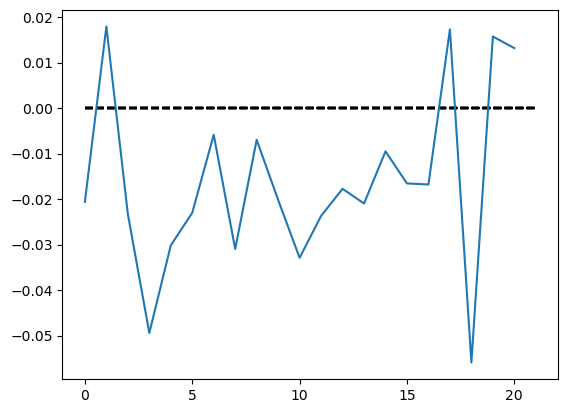

In [14]:
LLs = []
models = []
for cc in range(len(vallam)):
    e = exp.load('color_exps_02_cc_'+str(cc), experiment_location='../experiments')
    LLs.append(np.mean(e.trials[0].LLs))
    models.append(e.trials[0].model)
    
    # put a horizontal line at zero
    plt.plot([0, len(vallam)], [0, 0], 'k--')
    
_ = plt.plot(LLs)

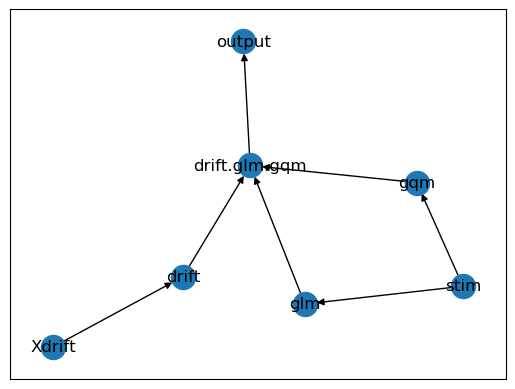

In [17]:
models[0].draw()

/home/mattjac/projects/mattjac/v1/NDNT/utils/DanUtils.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols)


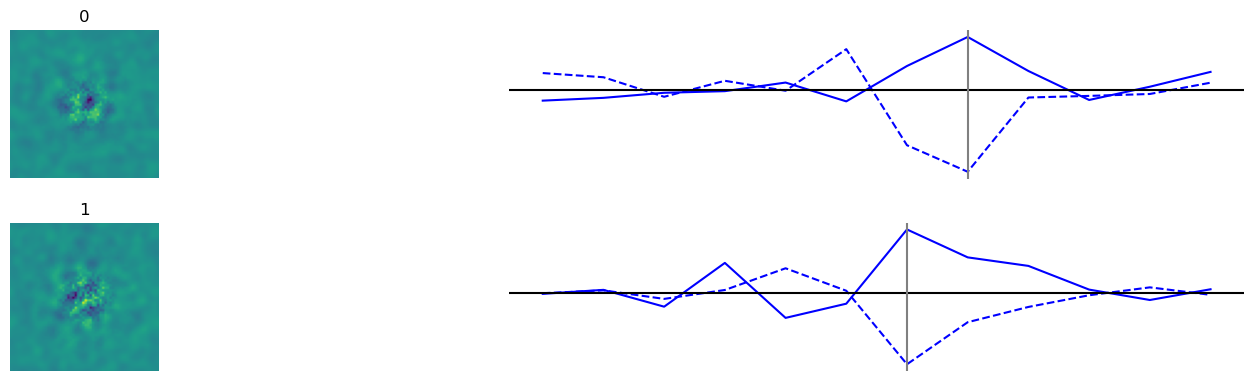

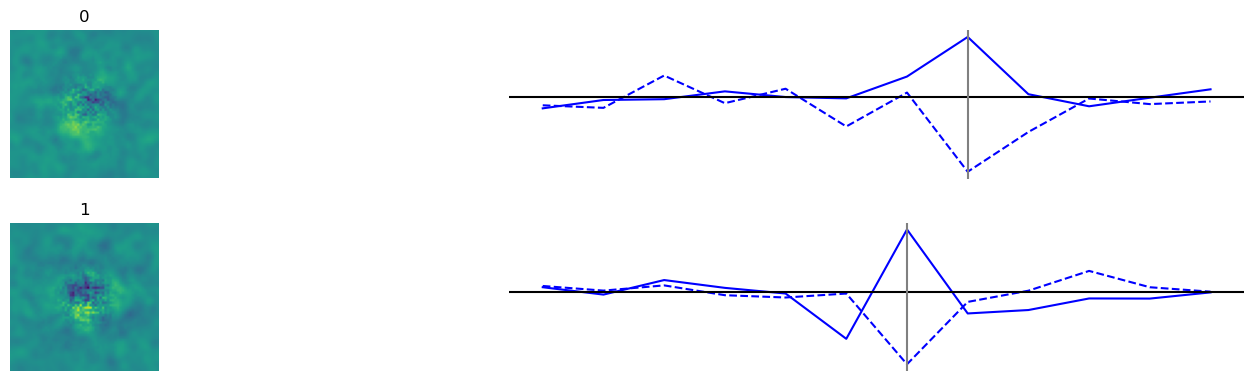

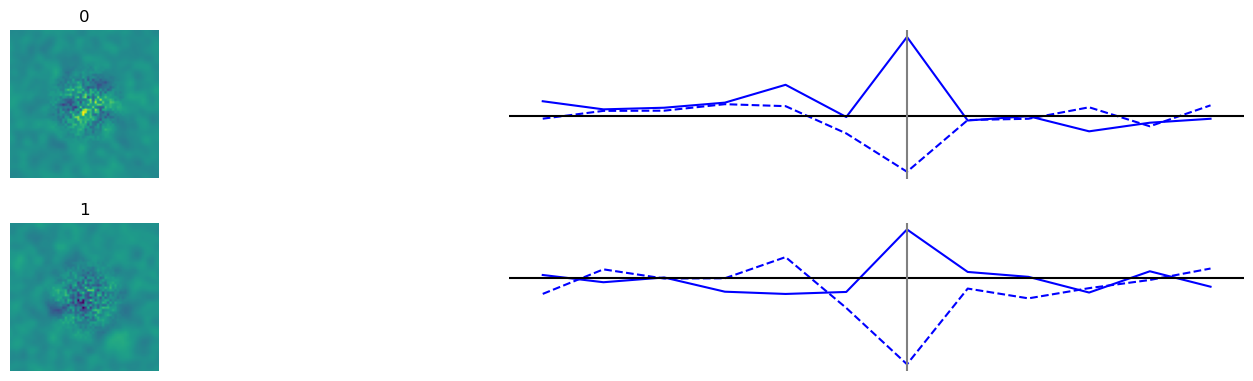

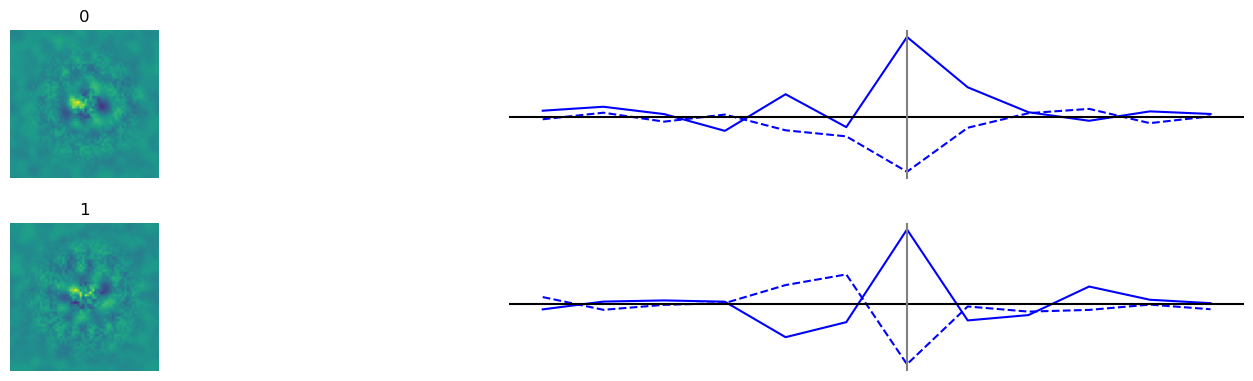

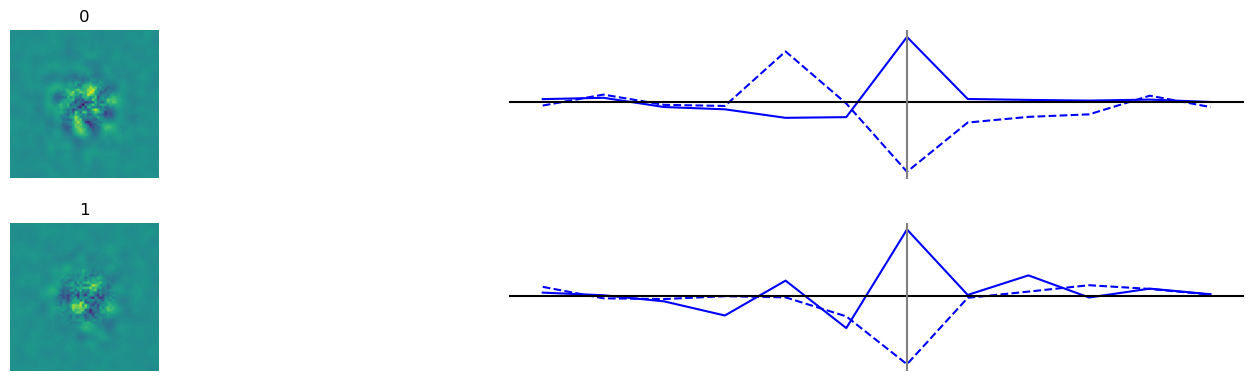

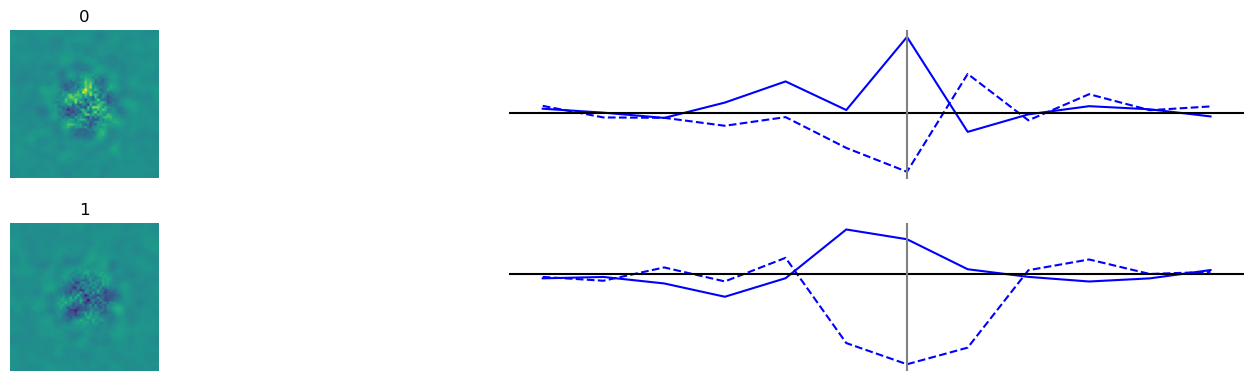

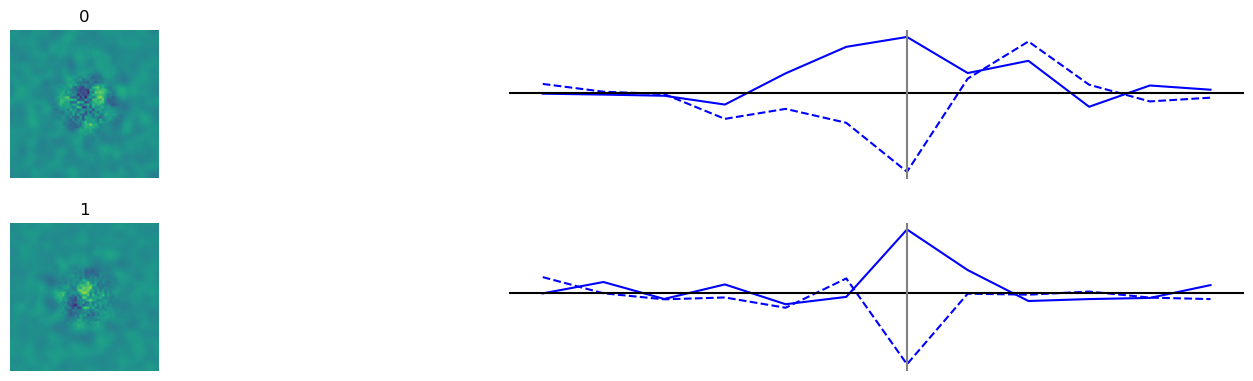

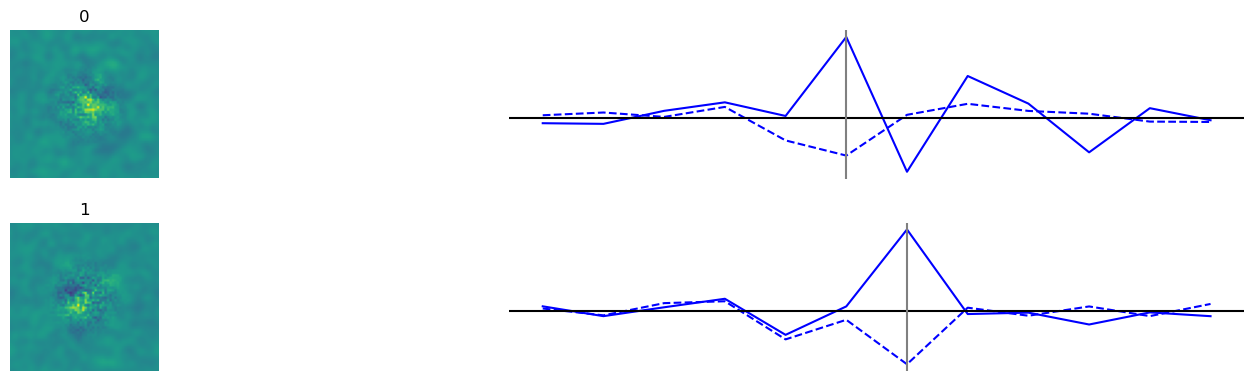

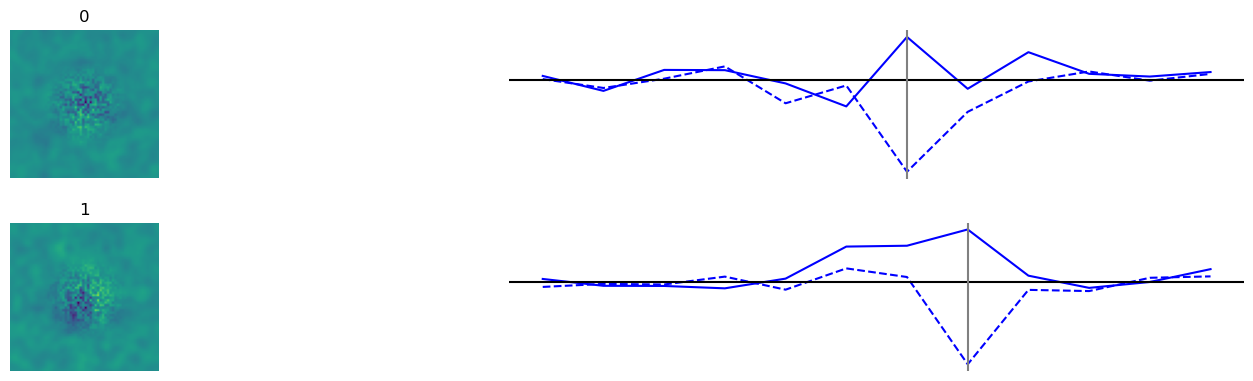

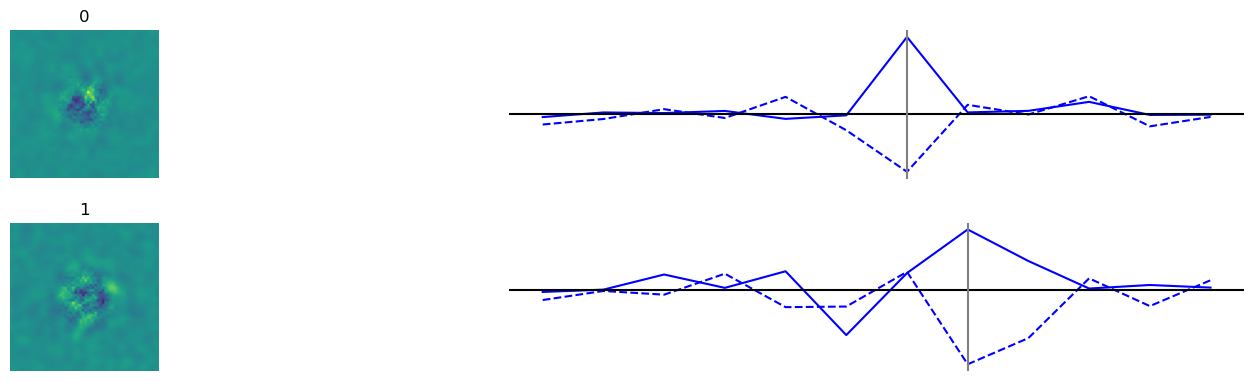

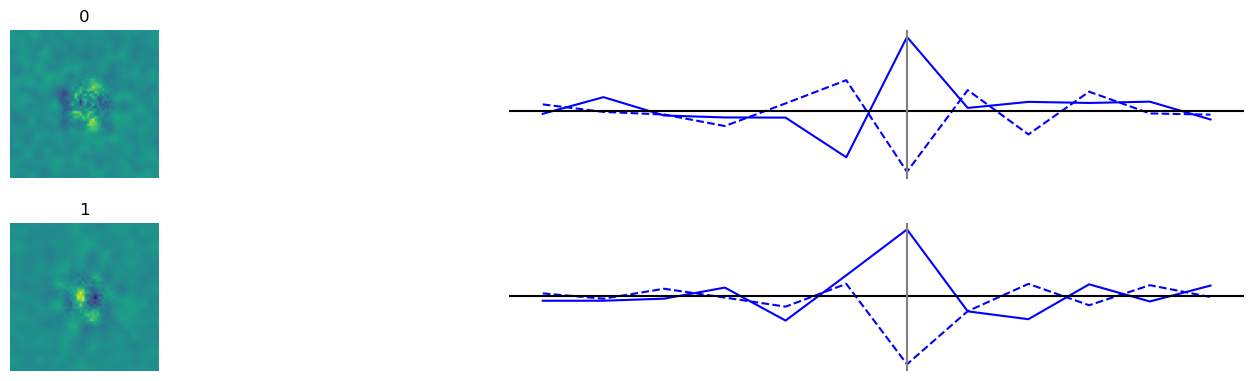

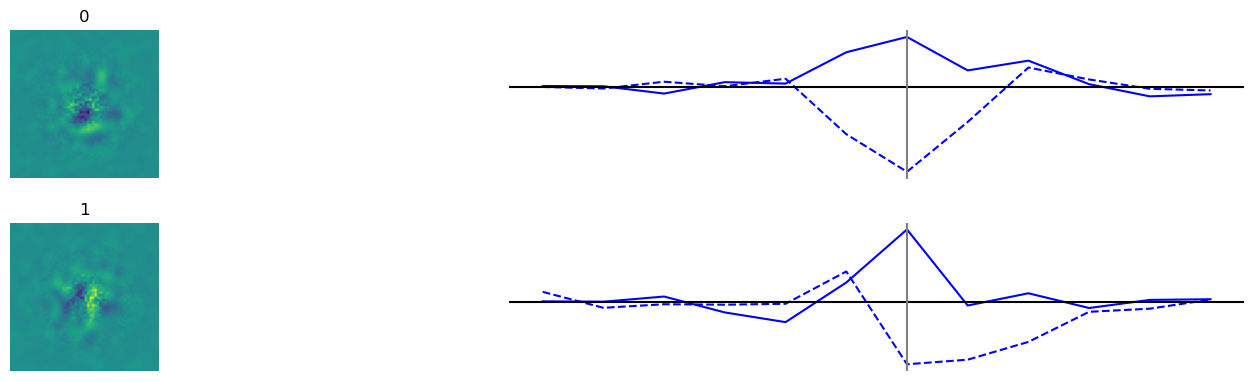

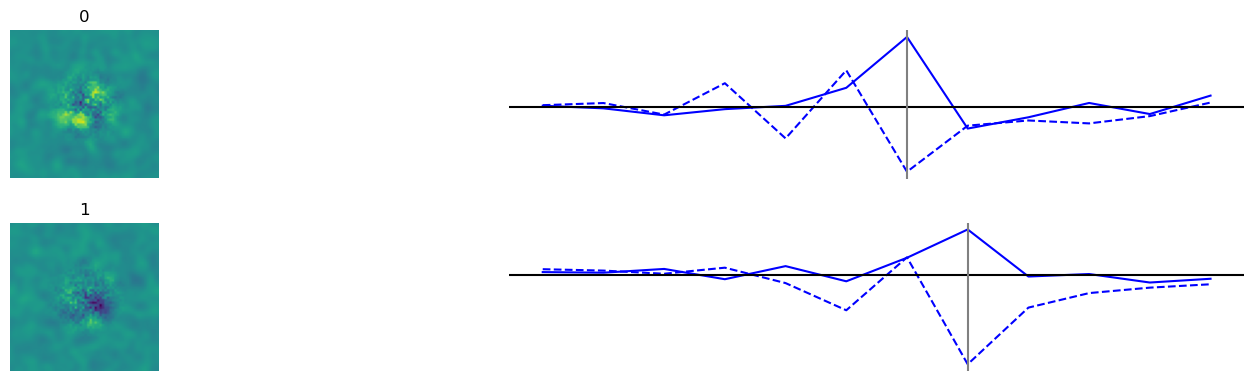

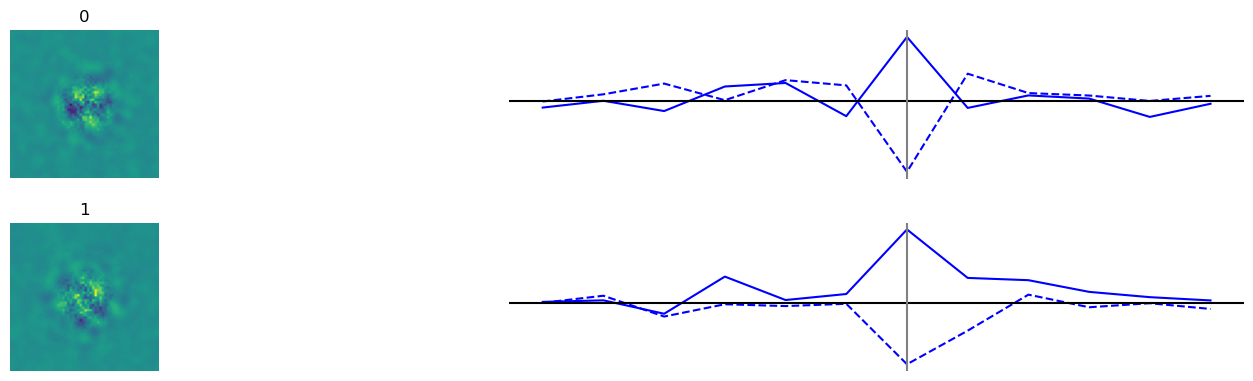

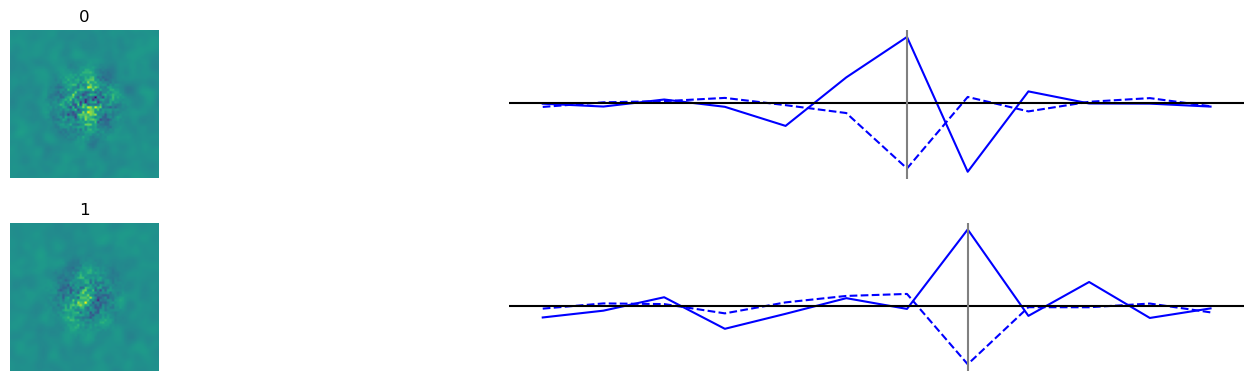

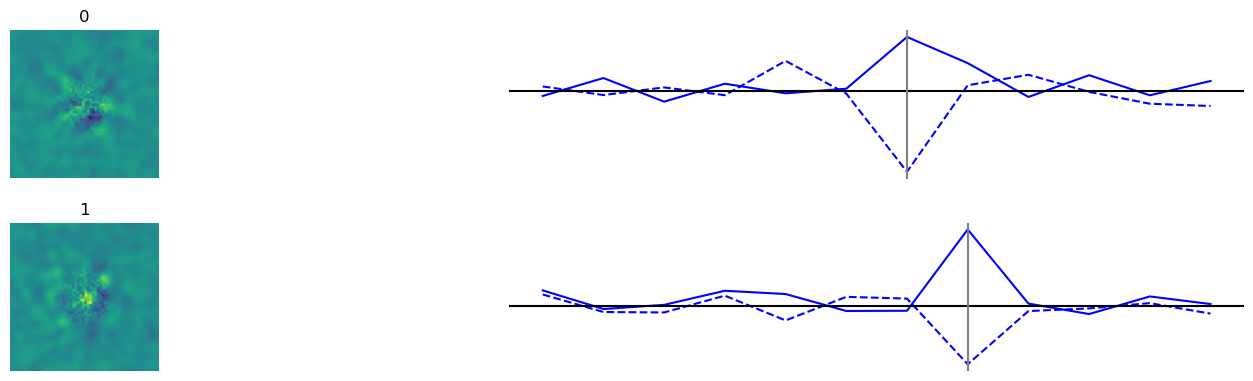

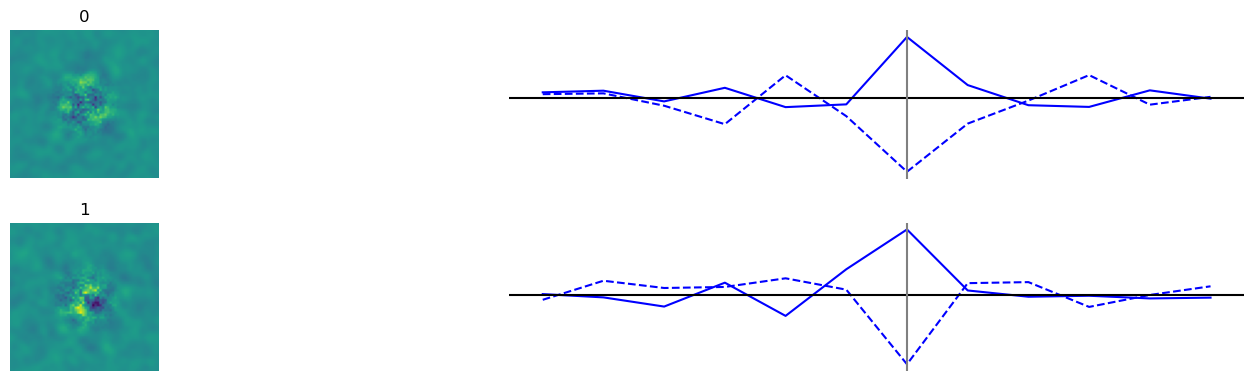

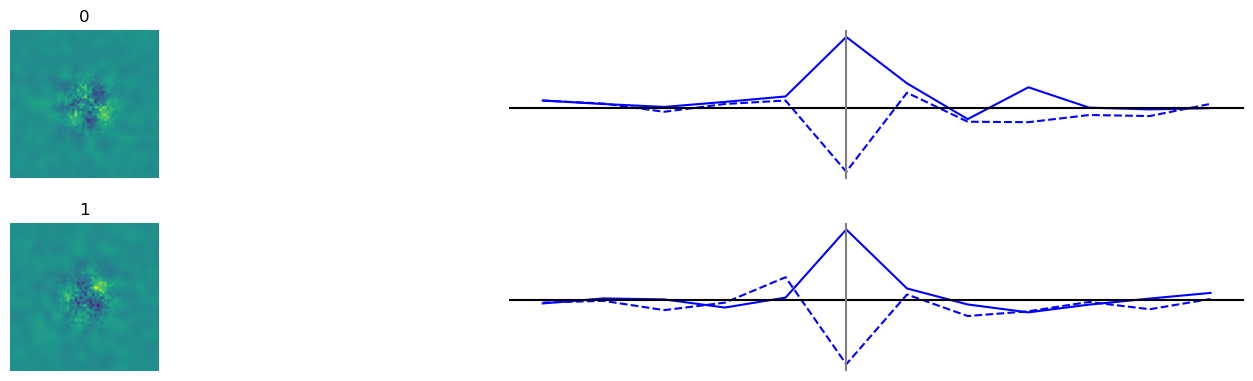

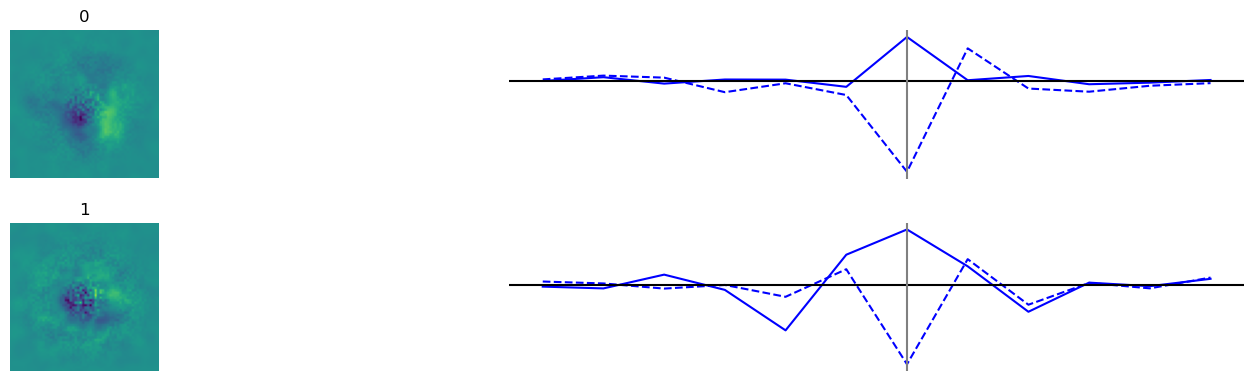

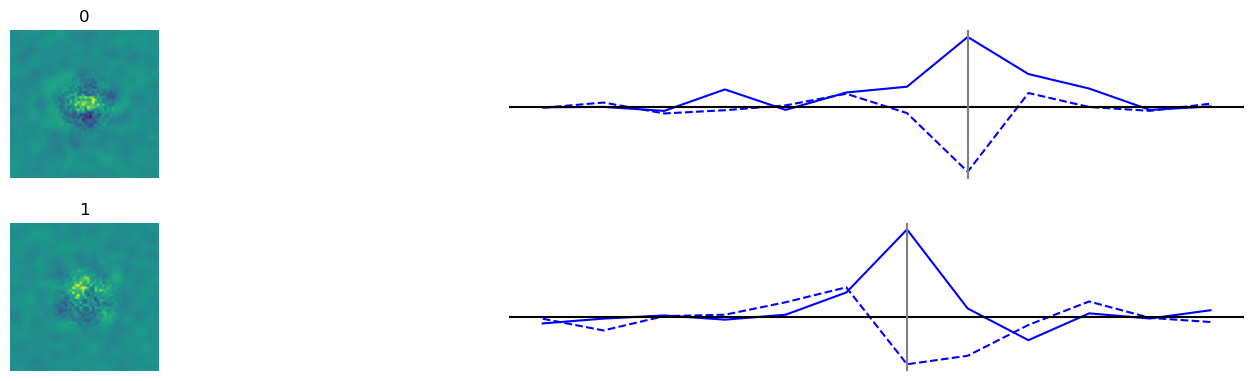

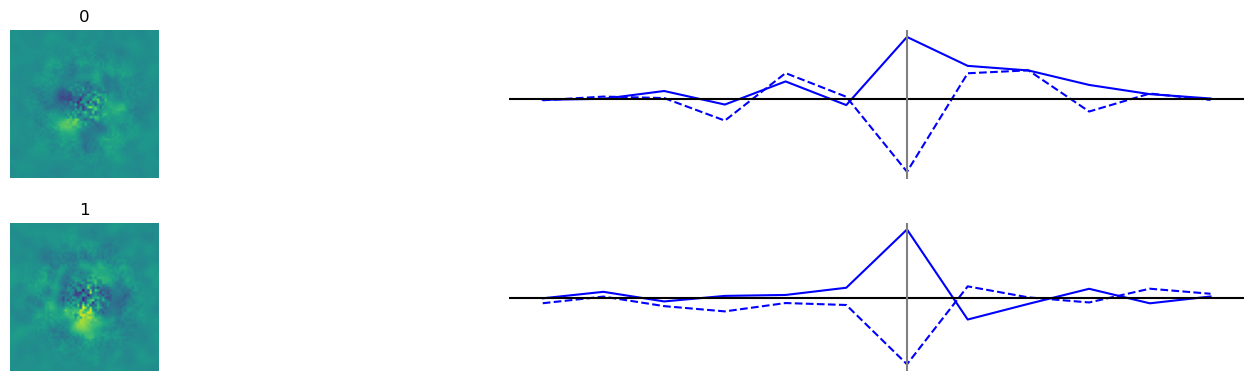

In [16]:
for model in models:
    model.NDN.plot_filters()